# LSTM Stock Predictor Using Fear and Greed Index


## Data Preparation

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [4]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [5]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [7]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
# Predict Closing Prices using a 10 day window of previous fng values
window_size = 7

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [9]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [10]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [11]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.33333333]
  [0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.41538462]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.32307692]]

 [[0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.53846154]]

 [[0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.54545455]
  [0.69230769]]

 [[0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.54545455]
  [0.6969697 ]
  [0.33846154]]] 

X_test sample values:
[[[0.45454545]
  [0.60606061]
  [0.60606061]
  [0.53030303]
  [0.53030303]
  [0.5       ]
  [0.44615385]]

 [[0.60606061]
  [0.60606061]
  [0.53030303]
  [0.53030303]
  [0.5       ]
  [0.45454545]
  [0.83076923]]

 [[0.60606061]
  [0.53030303]
  [0.53030303]
  [0.5       ]
  [0.45454545]
  [0.83333333]
  [0.86153846]]

 [[0.53030303]
  [0.53030303]
  [0.5       ]
  [0.45454545]
  [0.83333333]
  [0.86363636]
  [0.76

---

## Build and Train the LSTM RNN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
# Build the LSTM model. 

model = Sequential()

number_units = 4
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

2021-11-24 20:38:31.402042: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 4)              96        
                                                                 
 dropout (Dropout)           (None, 7, 4)              0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 4)              144       
                                                                 
 dropout_1 (Dropout)         (None, 7, 4)              0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 144       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [16]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
374/374 [==============================] - 12s 12ms/step - loss: 0.0772
Epoch 2/10
374/374 [==============================] - 6s 15ms/step - loss: 0.0551
Epoch 3/10
374/374 [==============================] - 6s 15ms/step - loss: 0.0446
Epoch 4/10
374/374 [==============================] - 6s 17ms/step - loss: 0.0455
Epoch 5/10
374/374 [==============================] - 8s 21ms/step - loss: 0.0446
Epoch 6/10
374/374 [==============================] - 8s 20ms/step - loss: 0.0446
Epoch 7/10
374/374 [==============================] - 4s 10ms/step - loss: 0.0448
Epoch 8/10
374/374 [==============================] - 6s 17ms/step - loss: 0.0428
Epoch 9/10
374/374 [==============================] - 5s 14ms/step - loss: 0.0447
Epoch 10/10
374/374 [==============================] - 5s 14ms/step - loss: 0.0450


---

## Model Performance

In [17]:
# Evaluate the model
model.evaluate(X_test, y_test)

6/6 [==============================] - 2s 5ms/step - loss: 0.1331


0.1330920159816742

In [18]:
# Make some predictions
predicted = model.predict(X_test)

In [19]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-19,3912.570068,5177.721191
2019-02-20,3924.239990,5266.063477
2019-02-21,3974.050049,5275.377930
2019-02-22,3937.040039,5321.927734
2019-02-23,3983.530029,5445.277832


<AxesSubplot:>

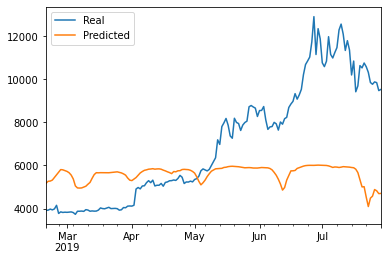

In [21]:
# Plot the real vs predicted values as a line chart
stocks.plot()

## SUMMARY

-1 Experimentingg various numbers from 1 to 10 for the window size, it seems like the lower numbers gives the better outcome hence a 1 day window yielded the best result

-2 The closing price model is more efficient than FNG value